In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

**PREPROCESSING_CLEANING**

In [166]:
df=pd.read_csv('D:/Semester 6/NLP/Assignment #3/urdu-sentiment-corpus-v1.tsv', sep='\t', header=0)
df = df[df['Class'] != 'O'] #dropping O as i will do binary classification

In [167]:
print(df['Class'].value_counts())
df.loc[df['Class'] == 'N', 'Class'] = 0
df.loc[df['Class'] == 'P', 'Class'] = 1

Class
N    499
P    480
Name: count, dtype: int64


In [168]:
df['Class'].value_counts()

Class
0    499
1    480
Name: count, dtype: int64

In [169]:
print(df.isnull().sum())
df=df.dropna()
print(df.isnull().sum())
print(df.head(5))

Tweet    0
Class    1
dtype: int64
Tweet    0
Class    0
dtype: int64
                                               Tweet Class
0  میں نے ایٹم بم بنایا ھے ۔۔۔۔او بھائی ایٹم بمب ...     1
1  چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن...     0
3  سرچ انجن گوگل کے نائب صدر نے فضا میں ، 130,000...     1
4    ابھی تک اسکی لہریں کبھی کبھی آ جاتی ہیں یار :أْ     1
5   گندی زبان اور گٹر جیسے دماغ والے جاهل جیالے ه...     0


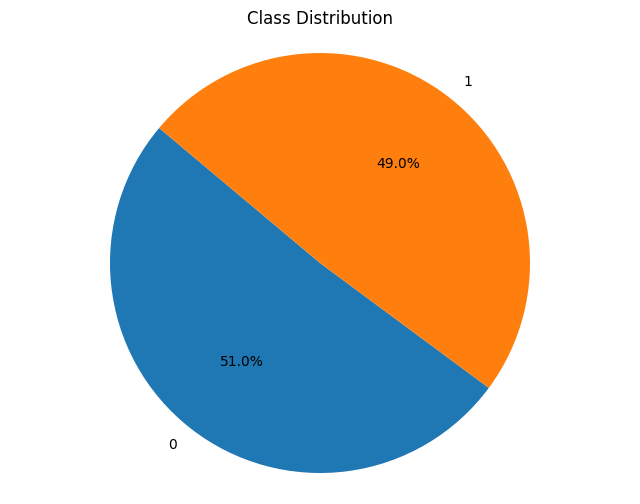

In [170]:
class_counts = df['Class'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.axis('equal')  
plt.show()


In [171]:
df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r'[^آ-ی\s]', '', x)) # removing everything except alpha values

def reverse_urdu(row):
    words = row.split() #split the words 
    reversed_sentence = ' '.join(reversed(words))  # reverse and rejoin
    return reversed_sentence

df['Tweet'] = df['Tweet'].apply(reverse_urdu)
df.head(5)

,Tweet,Class
0,ایٹمی کی کہوٹہ بم بنتاایٹم نہیں میں فیکٹری اتف...,1
1,سکت بن نہیں اعظم وزیر خان عمران اور انقلاب س چند,0
3,کی چھلانگ کرلیا قائم ریکارڈ عالمی کر لگا چھلان...,1
4,أْ یار ہیں جاتی آ کبھی کبھی لہریں اسکی تک ابھی,1
5,نهیں ممکن یه هو نه جاهل اور هو جیالا تم هو جیا...,0


In [172]:
stopwordsssssss=set([
    "کوئی", "نہیں", "کہ", "کر", "جائیں", "مجھے", "یہ", "بہت", "ہے", "سچ", 
    "تو", "میری", "کی", "آواز", "آجاتی", "ایک", "سے", "پورا", "کاسہ", "ڈالا"
])

df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join(word for word in x.split() if word not in stopwordsssssss))  # Remove stop words

**DATA_PREPARATION**

In [173]:
from sklearn.model_selection import train_test_split

X = df['Tweet'].values
y = df['Class'].values.astype("int32")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [174]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_words=4000
tokenizer = Tokenizer(num_words=4000) #sligtly larger value than the actual number of unique words
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

num_unique_words = len(tokenizer.word_index)
print(num_unique_words)

3715


In [175]:
average_words_per_row = df['Tweet'].apply(lambda x: len(x.split())).mean() #will use this to determine padding maximum length
print(average_words_per_row)

15.183861082737486


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 25  
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [ ]:
from tensorflow.keras.utils import to_categorical

num_classes=2
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)
y_test = y_test.astype(int)

**HELPING_FUNCTIONS**

In [177]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', zero_division=1)
    recall = recall_score(y_true, y_pred, average='binary', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='binary', zero_division=1)
    return accuracy, precision, recall, f1


In [ ]:
def Run_Model(model_creator):
    results = []

    layers = [2, 3]
    dropout_rates = [0.3, 0.7]
    
    for layer in layers:
        for dropout in dropout_rates:
            model = model_creator(layer, dropout)
            y_pred_prob = model.predict(X_test_pad)
            y_pred = np.argmax(y_pred_prob, axis=1)
            y_pred = y_pred.astype(int)
            
            accuracy, precision, recall, f1 = evaluate_model(y_test, y_pred)

            results.append({
                'Layers': layer,
                'Dropout': dropout,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-score': f1
            })

    return pd.DataFrame(results)

**LSTM_MODEL**

In [181]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

def create_train_model_LSTM(layers, dropout):
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len)) #using 100 so it captures some more relationship our corpus is to small
    for _ in range(layers):
        model.add(LSTM(64, dropout=dropout, return_sequences=True))
    model.add(LSTM(64, dropout=dropout))
    model.add(Dense(2, activation='sigmoid')) #using 2 neuron dense layer because of binary classification 
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_pad, y_train_cat, epochs=5, batch_size=128, verbose=0)
    return model

In [182]:
LSTM_results = Run_Model(create_train_model_LSTM)
print(LSTM_results)

8/8 [==============================] - 1s 8ms/step
   Layers  Dropout  Accuracy  Precision    Recall  F1-score
0       2      0.3  0.628571   0.693548  0.373913  0.485876
1       2      0.7  0.567347   0.524590  0.834783  0.644295
2       3      0.3  0.510204   0.489083  0.973913  0.651163
3       3      0.7  0.522449   0.494898  0.843478  0.623794


**BILSTM_MODEL**

In [183]:
from tensorflow.keras.layers import Bidirectional, LSTM

def create_train_model_BILSTM(layers, dropout):
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    for _ in range(layers): 
        model.add(Bidirectional(LSTM(64, dropout=dropout, return_sequences=True)))
    model.add(Bidirectional(LSTM(64, dropout=dropout)))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_pad, y_train_cat, epochs=5, batch_size=128, verbose=0)
    return model

In [184]:
BILSTM_results = Run_Model(create_train_model_BILSTM)
print(BILSTM_results)

8/8 [==============================] - 2s 13ms/step
   Layers  Dropout  Accuracy  Precision    Recall  F1-score
0       2      0.3  0.591837   0.546584  0.765217  0.637681
1       2      0.7  0.624490   0.632184  0.478261  0.544554
2       3      0.3  0.628571   0.650000  0.452174  0.533333
3       3      0.7  0.608163   0.702128  0.286957  0.407407


**RNN_MODEL**

In [185]:
from tensorflow.keras.layers import SimpleRNN

def create_train_model_RNN(layers, dropout):
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    for _ in range(layers):
        model.add(SimpleRNN(64, dropout=dropout, return_sequences=True))
    model.add(SimpleRNN(64, dropout=dropout))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_pad, y_train_cat, epochs=5, batch_size=128, verbose=0)
    return model


In [186]:
RNN_results = Run_Model(create_train_model_RNN)
print(RNN_results)

8/8 [==============================] - 1s 15ms/step
   Layers  Dropout  Accuracy  Precision    Recall  F1-score
0       2      0.3  0.518367   0.491620  0.765217  0.598639
1       2      0.7  0.465306   0.462617  0.860870  0.601824
2       3      0.3  0.526531   0.496970  0.713043  0.585714
3       3      0.7  0.522449   0.466667  0.121739  0.193103


**GRU_MODEL**

In [187]:
from tensorflow.keras.layers import GRU

def create_train_model_GRU(layers, dropout):
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    for _ in range(layers):
        model.add(GRU(64, dropout=dropout, return_sequences=True))
    model.add(GRU(64, dropout=dropout))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [188]:
GRU_results = Run_Model(create_train_model_GRU)
print(GRU_results)

8/8 [==============================] - 1s 11ms/step
   Layers  Dropout  Accuracy  Precision    Recall  F1-score
0       2      0.3  0.453061   0.412844  0.391304  0.401786
1       2      0.7  0.526531   0.496241  0.573913  0.532258
2       3      0.3  0.551020   0.526882  0.426087  0.471154
3       3      0.7  0.518367   0.488889  0.573913  0.528000


**COMPARISON_MODEL**

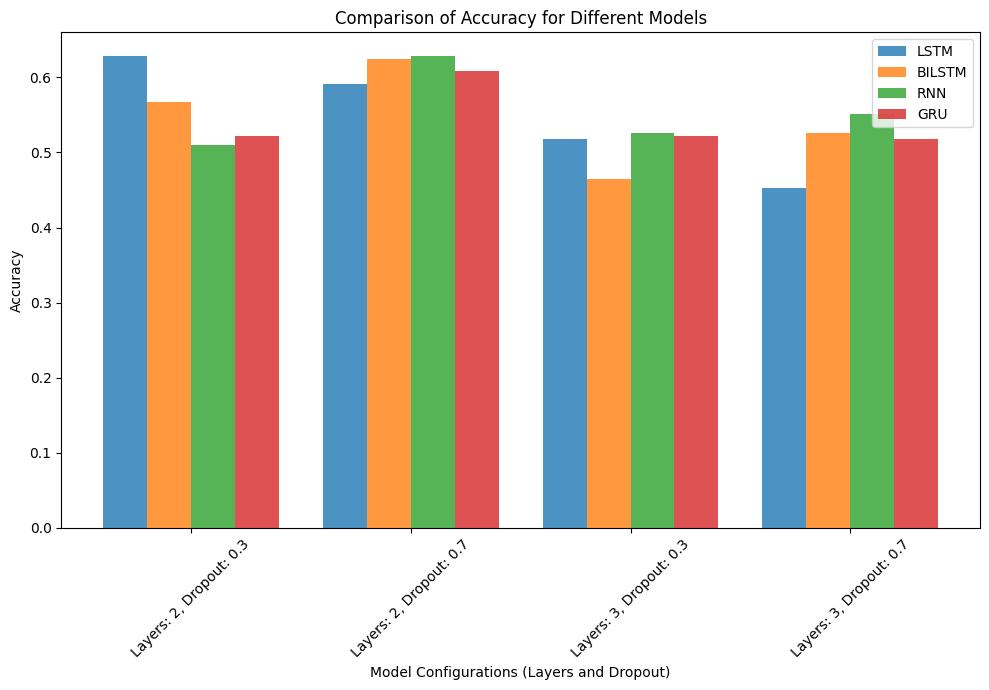

In [205]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dfs = [LSTM_results,BILSTM_results,RNN_results,GRU_results]
names=['LSTM','BILSTM','RNN','GRU']
i=0

merged_df = pd.concat(dfs)


grouped_df = merged_df.groupby(['Layers', 'Dropout'])


bar_width = 0.2
opacity = 0.8
index = np.arange(len(grouped_df))

plt.figure(figsize=(10, 7))

for i, ((layer, dropout), group) in enumerate(grouped_df):
    plt.bar(index + i * bar_width, group['Accuracy'], bar_width, alpha=opacity, label=names[i])
    i+1

plt.xlabel('Model Configurations (Layers and Dropout)')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy for Different Models')
plt.xticks(index + bar_width * (len(dfs) - 1) / 2, [f'Layers: {layer}, Dropout: {dropout}' for (layer, dropout), _ in grouped_df], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


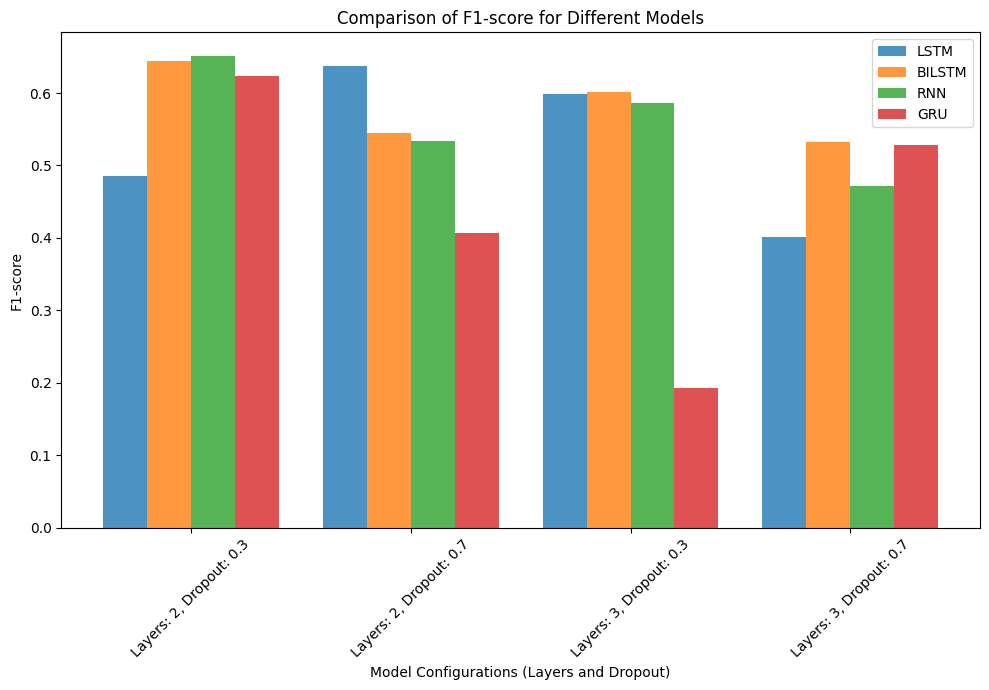

In [206]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dfs = [LSTM_results,BILSTM_results,RNN_results,GRU_results]
names=['LSTM','BILSTM','RNN','GRU']
i=0

merged_df = pd.concat(dfs)


grouped_df = merged_df.groupby(['Layers', 'Dropout'])


bar_width = 0.2
opacity = 0.8
index = np.arange(len(grouped_df))

plt.figure(figsize=(10, 7))

for i, ((layer, dropout), group) in enumerate(grouped_df):
    plt.bar(index + i * bar_width, group['F1-score'], bar_width, alpha=opacity, label=names[i])
    i+1

plt.xlabel('Model Configurations (Layers and Dropout)')
plt.ylabel('F1-score')
plt.title('Comparison of F1-score for Different Models')
plt.xticks(index + bar_width * (len(dfs) - 1) / 2, [f'Layers: {layer}, Dropout: {dropout}' for (layer, dropout), _ in grouped_df], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()
